# PHARE from a jupyter notebook

First make **pyhphare** and dynamic libraries available to the PYTHONPATH

In [1]:
import sys
sys.path.append("/Users/nicolas/Documents/code/phare/PHARE/pyphare/")
sys.path.append("/Users/nicolas/Documents/code/phare/build-PHARE-clang-Debug/")

## Load packages
Then load python packages that allows defining the simulation input parameters, initialize and run the simulation, as well as loading data and plot it

In [2]:
from pyphare.pharesee.hierarchy import hierarchy_from
from pyphare.simulator.simulator import create_simulator
from pyphare.pharein import MaxwellianFluidModel
from pyphare.pharein import ElectronModel
from pyphare.pharein.diagnostics import ElectromagDiagnostics, FluidDiagnostics
from pyphare.pharein.simulation import Simulation

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
# reset
from pyphare.pharein import globals
globals.sim =None

## Define the input simulation parameters

### Simulation block

The following block let us define the user input parameters for the simulation. Here we define a simulation that will run until $t=30\Omega_{ci}^{-1}$ for 30000 time steps of the coarsest domain. Boundary conditions are periodic, and the domain is divided in 40 cells of $0.3\delta_i$ size in the coarsest AMR level.

There is a predefined maximum of 2 AMR levels and the refined level is fixed between cells 10 and 20 of the coarsest level (i.e. it has 20 refined cells since refinement ratio is 2).

AMR patches are created by SAMRAI and are of size 20 cells wide.  

All the other parameters are assumed to take their default values



In [4]:
Simulation(
    smallest_patch_size=20,
    largest_patch_size=20,
    time_step_nbr=30000,        # number of time steps (not specified if time_step and final_time provided)
    final_time=30.,             # simulation final time (not specified if time_step and time_step_nbr provided)
    boundary_types="periodic", # boundary condition, string or tuple, length == len(cell) == len(dl)
    cells=40,                # integer or tuple length == dimension
    dl=0.3,                  # mesh size of the root level, float or tuple
    max_nbr_levels=2,          # (default=1) max nbr of levels in the AMR hierarchy
    refinement_boxes={"L0": {"B0": [(10, ), (20, )]}},
    diag_options={"format": "phareh5", "options": {"dir": "phare_outputs"}}
)

### Initial profiles

So far only the `MaxwellianFluidModel` can initialize PHARE. This means the user can supply any python function that provide the moments ($n$, $\mathbf{V}$ and $\mathbf{V}_{th}$) of all populations of the plasma (with an arbirary number of them) and the magnetic field profile.

The `MaxwellianFluidModel` then loads all ion particule populations assuming a local Maxwellian distribution functions with the prescribed profiles

These functions can be of arbitrary complexity as long as they respect the dimensionality (i.e. depend only on $x$ in 1D), respect the predefined names. If any is missing, default functions will be used.

In [5]:
def density(x):
    return 1.


def by(x):
    from pyphare.pharein.globals import sim
    L = sim.simulation_domain()
    return 0.1*np.cos(2*np.pi*x/L[0])

def bz(x):
    from pyphare.pharein.globals import sim
    L = sim.simulation_domain()
    return 0.1*np.sin(2*np.pi*x/L[0])

def bx(x):
    return 1.

def vx(x):
    return 0.

def vy(x):
    from pyphare.pharein.globals import sim
    L = sim.simulation_domain()
    return 0.1*np.cos(2*np.pi*x/L[0])

def vz(x):
    from pyphare.pharein.globals import sim
    L = sim.simulation_domain()
    return 0.1*np.sin(2*np.pi*x/L[0])

def vthx(x):
    return 0.01

def vthy(x):
    return 0.01

def vthz(x):
    return 0.01


MaxwellianFluidModel(bx=bx, by=by, bz=bz,
                     protons={"charge": 1,
                     "density": density,
                     "vbulkx": vx, "vbulky": vy, "vbulkz": vz,
                     "vthx": vthx, "vthy": vthy, "vthz": vthz,
                     "init": {"seed": 1337}}
)

### Electron model

PHARE is a Hybrid-PIC code, therefore assumes fluid electrons and the user must choose a closure to their fluid state. So far, only the isothermal closure is available, where the electron temperature is a spatial and temporal constant that the user sets.

In [6]:
ElectronModel(closure="isothermal", Te=0.12)

## Create and initialize the simulation

The following cell creates the simulator associated with the above defined parameters
In addition to the `simulator`, it returns the diagnostic manager (`dman`) and the SAMRAI PatchHierarchy wrapper `hier`.

Once the simulator created, it is used to initialize the simulation

In [8]:
dman, simulator, hier = create_simulator()
simulator.initialize()

## Getting the data

There are two ways to get the data from PHARE:

- from diagnostic files
- from a `simulator` instance.

The first is usually preferable when analyzing data from a previously ran simulation. The second way directly extract copies of the current state of the AMR hierarchy in form of a python data Hierarchy

In [9]:
density_hierarchy = hierarchy_from(simulator, hier,  "density")

Printed hierarchies gives an idea of their structure, in terms of patch boxes per level

In [10]:
print(density_hierarchy)

t = 0.0
Hierarchy: 
Level 0
    P0 density box is [ 0,19 ] and ghost box is [ -5,24 ]
    P1 density box is [ 20,39 ] and ghost box is [ 15,44 ]
Level 1
    P0 density box is [ 20,41 ] and ghost box is [ 15,46 ]



plotting a data hierarchy is the graphical equivalent to printing, it represents patches per level

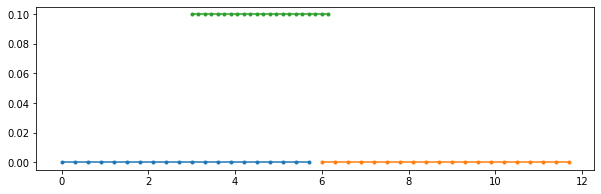

In [11]:
density_hierarchy.plot()

From the data hierarchy, one can plot the data.
In the following cell, we loop over all levels at t=0 (time at which the hierarchy is currently defined) and for each of them, we loop over each Patch, to get the density and plot it.

Text(0.5, 1.0, 't = 00.00')

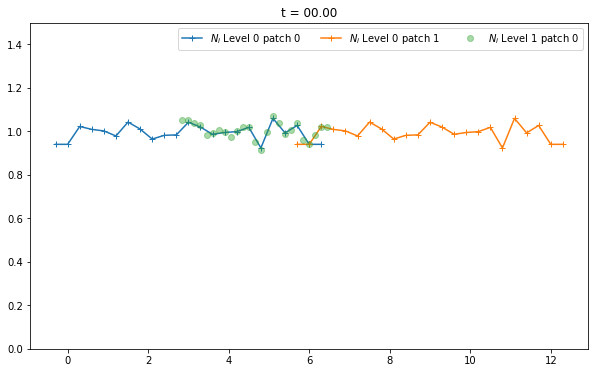

In [16]:
times = np.sort(np.asarray(list(density_hierarchy.time_hier.keys())))
fig,ax = plt.subplots(figsize=(10,6))
t = 0
for il,level in density_hierarchy.levels(t).items():
    patches = level.patches
    if il==0:
        marker="+"
        alpha=1
        ls='-'
    else:
        marker="o"
        alpha=0.4
        ls='none'
    for ip,patch in enumerate(patches):
        val         = patch.patch_datas["density"].dataset[:]
        x_val       = patch.patch_datas["density"].x
        ax.plot(x_val, val, label=r"$N_i$ Level {} patch {}".format(il,ip), marker=marker,alpha=alpha,ls=ls)
        ax.set_ylim((0,1.5))
ax.legend(ncol=4)
ax.set_title("t = {:05.2f}".format(t))